<a href="https://colab.research.google.com/github/tirals88/predicting_pm2.5/blob/main/August/PM_pred_new1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 문제 해결 목표
이전까지 AIFactory 문제에서는 input data scale : 261 or 167 columns (위/경도 데이터 차이)

167columns : 30개의 AWS관측소 (기온(°C)	풍향(deg)	풍속(m/s)	강수량(mm)	습도(%)) 총 5개의 AWS data + 17개의 PM2.5 관측소의 PM2.5 data

이는 총 47개의 관측데이터를 통해 17개의 PM2.5 관측소의 동시 예측을 해야하는 문제

위 문제를 아래 세 가지로 변경할 계획

1. 30개의 AWS 관측소 + 1개의 $A$지역 PM2.5 관측소 -> 1개의 $A$지역 PM2.5 관측소 예측
2. $A$지역 PM2.5 관측소 기준 반경 $X$ 내의 AWS 관측소 -> $A$지역 PM2.5 관측소 예측
3. (2)의 input 데이터 + 반경 $Y$ 내의 PM2.5 관측소

$X와 Y$는 위/경도를 기준으로 할 수 있음

https://www.airkorea.or.kr/web/dustForecast?pMENU_NO=113
환경부 PM2.5 예측을 보면 이틀치의 예측을 하기에 위 세 문제도 48hours 이하의 ouput time steps를 가질 것임

input time steps를 정하는 기준은 data의 비교를 통해 결정 할 예정

## 가까운 PM2.5와 AWS 관측소 하나 씩의 데이터 비교

- PM2.5 관측소 : 신방동 (36.7823546,	127.1205056)
-  AWS 관측소 1: 성거 (36.8782,	127.1561) // **0.1022413908968373**
-  AWS 관측소 2: 세종전의 (36.6908,	127.2005) //  **0.12157857053165125**

In [ ]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 3903470289184584091
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14328594432
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 12175379292609427888
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
 xla_global_id: 416903419]

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# 데이터 확인
import os
data = '/content/drive/MyDrive/AIFactory/dataset'
file_type = ['/TRAIN', '/TRAIN_AWS', '/TEST_INPUT', '/TEST_AWS']
train_list = os.listdir(data+file_type[0])
train_AWS_list = os.listdir(data+file_type[1])

print(train_list)
print(train_AWS_list)

print("Train_list : {}".format(len(train_list)))
print("Train_AWS_list : {}".format(len(train_AWS_list)))

['공주.csv', '읍내동.csv', '신흥동.csv', '모종동.csv', '문창동.csv', '정림동.csv', '신방동.csv', '독곶리.csv', '이원면.csv', '성성동.csv', '노은동.csv', '아름동.csv', '홍성읍.csv', '대천2동.csv', '동문동.csv', '예산군.csv', '논산.csv']
['공주.csv', '계룡.csv', '논산.csv', '성거.csv', '북격렬비도.csv', '세종고운.csv', '당진.csv', '세천.csv', '정산.csv', '대산.csv', '세종연서.csv', '세종금남.csv', '청양.csv', '세종전의.csv', '아산.csv', '유구.csv', '서천.csv', '양화.csv', '장동.csv', '정안.csv', '대천항.csv', '예산.csv', '안도.csv', '옹도.csv', '오월드.csv', '호도.csv', '춘장대.csv', '태안.csv', '홍북.csv', '홍성죽도.csv']
Train_list : 17
Train_AWS_list : 30


### input 데이터의 길이를 3일로 지정

- 72hours 로 하니까 runtime error / ram 용량 초과로 60hours 로 변경

- column scale 은 167에서 151로 줄어들지만, time_step 이 48에서 72가 될 때 1.5배가 되기 때문에 오히려 더 큰 table 이 되어버림

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

train_data = pd.read_csv('/content/drive/MyDrive/colabnotebooks/data/data1.csv', index_col = 0) # index_col 없을 때 'Unnamed col : 0' 생김
train_data.interpolate(limit_direction='both')

,기온(°C),풍향(deg),풍속(m/s),강수량(mm),습도(%),기온(°C).1,풍향(deg).1,풍속(m/s).1,강수량(mm).1,습도(%).1,...,풍향(deg).28,풍속(m/s).28,강수량(mm).28,습도(%).28,기온(°C).29,풍향(deg).29,풍속(m/s).29,강수량(mm).29,습도(%).29,PM2.5
0,0.173776,0.201944,0.023018,0.0,0.828,0.154818,0.410833,0.033248,0.0,0.830,...,0.000000,0.002558,0.0,0.865,0.251185,0.012778,0.181586,0.0,0.733,0.056
1,0.176935,0.168611,0.030691,0.0,0.831,0.142180,0.148611,0.030691,0.0,0.853,...,0.280833,0.081841,0.0,0.875,0.254344,0.009722,0.189258,0.0,0.718,0.060
2,0.180095,0.087222,0.033248,0.0,0.784,0.173776,0.203889,0.040921,0.0,0.802,...,0.275556,0.066496,0.0,0.870,0.255924,0.016389,0.189258,0.0,0.692,0.068
3,0.178515,0.087222,0.025575,0.0,0.745,0.169036,0.330556,0.048593,0.0,0.816,...,0.259167,0.033248,0.0,0.852,0.254344,0.016944,0.194373,0.0,0.697,0.060
4,0.164297,0.113889,0.020460,0.0,0.750,0.169036,0.000000,0.007673,0.0,0.827,...,0.257222,0.020460,0.0,0.882,0.252765,0.003333,0.189258,0.0,0.684,0.068
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35059,0.287520,0.765833,0.071611,0.0,0.577,0.265403,0.101944,0.025575,0.0,0.596,...,0.832222,0.086957,0.0,0.671,0.317536,0.953333,0.230179,0.0,0.630,0.052
35060,0.281201,0.753056,0.063939,0.0,0.586,0.252765,0.338056,0.015345,0.0,0.594,...,0.831667,0.043478,0.0,0.692,0.309637,0.984167,0.253197,0.0,0.648,0.056
35061,0.260664,0.000000,0.010230,0.0,0.674,0.257504,0.970556,0.040921,0.0,0.575,...,0.832500,0.066496,0.0,0.706,0.308057,0.966667,0.265985,0.0,0.648,0.052
35062,0.262243,0.011944,0.020460,0.0,0.660,0.262243,0.908056,0.030691,0.0,0.611,...,0.866944,0.043478,0.0,0.725,0.306477,0.976667,0.235294,0.0,0.642,0.052


### 30개의 AWS 측정소 ( 각 5개의 data ) + 1개의 PM2.5 측정소 ( '공주', PM2.5, 1개의 data )

In [ ]:
# Tensorflow / Keras
from tensorflow import keras # for building Neural Networks
print('Tensorflow/Keras: %s' % keras.__version__) # print version
from keras.models import Sequential # for creating a linear stack of layers for our Neural Network
from keras import Input # for instantiating a keras tensor
from keras.layers import Bidirectional, GRU, RepeatVector, Dense, TimeDistributed # for creating layers inside the Neural Network

# Data manipulation
import pandas as pd # for data manipulation
print('pandas: %s' % pd.__version__) # print version
import numpy as np # for data manipulation
print('numpy: %s' % np.__version__) # print version

# Sklearn
import sklearn
print('sklearn: %s' % sklearn.__version__) # print version
from sklearn.preprocessing import MinMaxScaler # for feature scaling

# Visualization
import plotly
import plotly.express as px
import plotly.graph_objects as go
print('plotly: %s' % plotly.__version__) # print version

Tensorflow/Keras: 2.12.0
pandas: 1.5.3
numpy: 1.23.5
sklearn: 1.2.2
plotly: 5.13.1


In [ ]:
#newmodel -1 : scaling / 213columns / 151cols
def split_train_val(train_data_, time_steps, for_periods):
  """
  input:
    data: 날짜를 인덱스로 가지는 AWS 데이터와 PM2.5 데이터
  ouput:
    X_train, Y_train: 0년 1월 1일 00시 ~ 03년 07월 02일 08시 (30681 개의 데이터)
    X_test : 03년 07월 02일 09시부터의 데이터 (4383개의 데이터)
    7:1 비율
  time_steps: # input data time steps : 3days/72hours
  for_periods: # output data time steps : 2days/48hours
  """
  # training & validation set
  # scale the data
  scaled_AWS = pd.DataFrame(columns=train_data_.columns[:-1])
  scaled_PM = pd.DataFrame(columns=train_data_.columns[-1:])
  sc__ = []

  #X_scaled = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0)) # X: original data, min: 0, max: 1

  for column in train_data_.columns[:-1]:
    data_ = train_data_[column].interpolate(limit_direction='both').values.reshape((-1, 1))
    scaled_data = ((data_ - data_.min()) / (data_.max()-data_.min())).reshape((len(data_), ))
    scaled_AWS[column] = scaled_data.tolist()
  # Y value / scale
  # for column in train_data_.columns[-1:]:
  #   data_ = train_data_[column].interpolate(limit_direction='both').values.reshape((-1, 1))
  #   scaled_data = ((data_ - data_.min()) / (data_.max()-data_.min())).reshape((len(data_), ))
  #   scaled_PM[column] = scaled_data.tolist()
  #   sc__.append((data_.min(), data_.max()))

  for column in train_data_.columns[-1:]:
    data_ = train_data_[column].interpolate(limit_direction='both').values.reshape((-1, 1))
    scaled_data = data_.reshape((len(data_), ))
    scaled_PM[column] = scaled_data.tolist()

  ## 결측치가 남아있는 경우가 있어서 다시 한 번 보간법 적용
  temp_train_AWS = scaled_AWS[:30682].interpolate(limit_direction='both').values
  temp_train_PM = scaled_PM[:30682].interpolate(limit_direction='both').values

  temp_val_AWS = scaled_AWS[30682:].interpolate(limit_direction='both').values
  temp_val_PM = scaled_PM[30682:].interpolate(limit_direction='both').values

  temp_train_len = len(temp_train_AWS)
  temp_val_len = len(temp_val_AWS)

  temp_train = np.concatenate((temp_train_AWS, temp_train_PM), axis = 1)

  # training data slicing
  X_train = []
  Y_train = []
  Y_train_stacked = []
  for i in range(time_steps, temp_train_len - (for_periods - 1)):

    X_train.append(temp_train[i-time_steps: i, :])
    Y_train.append(temp_train[i:i+for_periods, -1:])
  X_train, Y_train = np.array(X_train), np.array(Y_train)

  #3차원으로 재구성
  X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 151))
  Y_train = np.reshape(Y_train, (Y_train.shape[0], Y_train.shape[1]))

  #Preparing to creat X_val
  #함수 처음 부분에서 numpy array 로 변동해서 pandas가 아닌 numpy로 concatenate
  inputs_train = np.concatenate((temp_train_AWS, temp_train_PM), axis = 1)
  inputs_val = np.concatenate((temp_val_AWS, temp_val_PM), axis = 1)
  inputs = np.concatenate((inputs_train, inputs_val), axis=0)
  inputs = inputs[len(inputs)- temp_val_len - time_steps : ]
  #inputs = inputs.reshape(-1,1)

  X_val = []
  Y_val = []
  for i in range(time_steps, temp_val_len+time_steps-for_periods+1):
    X_val.append(inputs[i - time_steps:i, :])
    Y_val.append(inputs[i:i+for_periods, -1:])
  X_val, Y_val = np.array(X_val), np.array(Y_val)
  X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1], 151))
  Y_val = np.reshape(Y_val, (Y_val.shape[0], Y_val.shape[1]))

  return X_train, Y_train, X_val, Y_val, sc__

In [ ]:
X_train, Y_train, X_val, Y_val, sc = split_train_val(train_data, 60, 48)

In [ ]:
#sc[0][1]

In [ ]:
X_train.shape

(30575, 60, 151)

In [ ]:
Y_train.shape

(30575, 48)

In [ ]:
X_train = X_train.astype(float)
Y_train = Y_train.astype(float)
X_val = X_val.astype(float)
Y_val = Y_val.astype(float)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, GRU, Permute, Flatten
from keras.optimizers import SGD
my_GRU_model_2 = Sequential()
#my_GRU_model.add(keras.layers.Flatten())
my_GRU_model_2.add(GRU(units = 100,
                    return_sequences = True,
                    input_shape = ((60, 151)),
                    activation = 'tanh'))
print(my_GRU_model_2.output_shape)

#my_GRU_model_2.add(Permute((2, 1), input_shape=(72, 20)))
#print(my_GRU_model_2.output_shape)

my_GRU_model_2.add(GRU(units = 50,
                    return_sequences = True,
                    activation = 'tanh'))

print(my_GRU_model_2.output_shape)

my_GRU_model_2.add(Flatten())

my_GRU_model_2.add(Dense(units = 48))
print(my_GRU_model_2.output_shape)

print(my_GRU_model_2.summary())

(None, 60, 100)
(None, 60, 50)
(None, 48)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 60, 100)           75900     
                                                                 
 gru_1 (GRU)                 (None, 60, 50)            22800     
                                                                 
 flatten (Flatten)           (None, 3000)              0         
                                                                 
 dense (Dense)               (None, 48)                144048    
                                                                 
Total params: 242,748
Trainable params: 242,748
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
def actual_pred_plot(preds, idx):
    """
    Plot the actual vs predition
    """
    actual_pred = pd.DataFrame(columns = ['PM2.5.0', 'prediction'])
    actual_pred['PM2.5.0'] = Y_val[idx, :]
    actual_pred['prediction'] = preds[idx, :]

    from keras.metrics import MeanSquaredError
    m = MeanSquaredError()
    m.update_state(np.array(actual_pred['PM2.5.0']), np.array(actual_pred['prediction']))

    return (m.result().numpy(), actual_pred.plot())

### GRU_new - 1

In [ ]:
#GRU_new - 1
def GRU_new1(X_train, Y_train, X_val, sc_):
    from keras.models import Sequential
    from keras.layers import Dense, SimpleRNN, GRU, Permute, Flatten
    from keras.optimizers import Adam

    # The GRU architecture
    my_GRU_model = Sequential()
    #my_GRU_model.add(keras.layers.Flatten())
    my_GRU_model.add(GRU(units = 100,
                         return_sequences = True,
                         input_shape = ((60, 151)),
                         activation = 'tanh'))
    my_GRU_model.add(GRU(units = 150,
                         return_sequences = True,
                         activation = 'tanh'))
    my_GRU_model.add(GRU(units = 60,
                         return_sequences = True,
                         activation = 'tanh'))

    my_GRU_model.add(Flatten())

    my_GRU_model.add(Dense(units = 48))

    # Compiling the RNN
    my_GRU_model.compile(optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.01, amsgrad=False),
                         loss = 'mean_squared_error')
    # Fitting to the trainig set
    history = my_GRU_model.fit(X_train, Y_train, epochs = 5, batch_size = 100, verbose = 1, validation_data=(X_val, Y_val))

    GRU_prediction = my_GRU_model.predict(X_val)
    print(GRU_prediction.shape)
    #GRU_prediction = sc_.inverse_transform(GRU_prediction)
    #GRU_prediction[:, :] = ((GRU_prediction[:, :] - sc[0][0])/(sc[0][1] - sc[0][0]))

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.legend(['train','val'])
    plt.show()
    return my_GRU_model, GRU_prediction

# (batch_size, time_seq, features)

Epoch 1/5
306/306 [==============================] - 16s 23ms/step - loss: 0.0056 - val_loss: 0.0029
Epoch 2/5
306/306 [==============================] - 5s 16ms/step - loss: 0.0036 - val_loss: 0.0028
Epoch 3/5
306/306 [==============================] - 4s 13ms/step - loss: 0.0034 - val_loss: 0.0028
Epoch 4/5
306/306 [==============================] - 4s 14ms/step - loss: 0.0033 - val_loss: 0.0028
Epoch 5/5
136/136 [==============================] - 1s 4ms/step
(4335, 48)


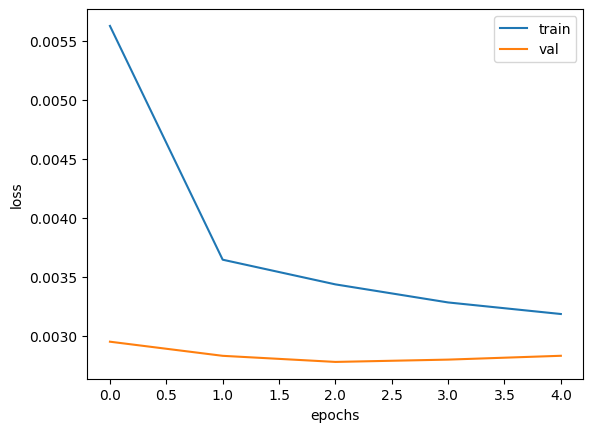

In [ ]:
my_GRU_model, GRU_prediction = GRU_new1(X_train, Y_train, X_val, sc)

In [ ]:
GRU_prediction

array([[0.03324246, 0.01691074, 0.02126123, ..., 0.03771157, 0.03000562,
        0.03390376],
       [0.03207455, 0.01463718, 0.01868782, ..., 0.03280106, 0.02575972,
        0.03261048],
       [0.03172287, 0.01422312, 0.01911313, ..., 0.02761851, 0.02394423,
        0.03446788],
       ...,
       [0.18630615, 0.21071434, 0.21344593, ..., 0.17623386, 0.19943373,
        0.19425622],
       [0.18662065, 0.21609111, 0.2196176 , ..., 0.18081725, 0.19837835,
        0.19849427],
       [0.18586668, 0.22280416, 0.22533284, ..., 0.18503873, 0.19288875,
        0.19911969]], dtype=float32)

In [ ]:
Y_val

array([[0.04 , 0.024, 0.04 , ..., 0.028, 0.028, 0.02 ],
       [0.024, 0.04 , 0.036, ..., 0.028, 0.02 , 0.012],
       [0.04 , 0.036, 0.032, ..., 0.02 , 0.012, 0.016],
       ...,
       [0.404, 0.408, 0.404, ..., 0.052, 0.056, 0.052],
       [0.408, 0.404, 0.376, ..., 0.056, 0.052, 0.052],
       [0.404, 0.376, 0.388, ..., 0.052, 0.052, 0.064]])

(0.0007394061, <Axes: >)

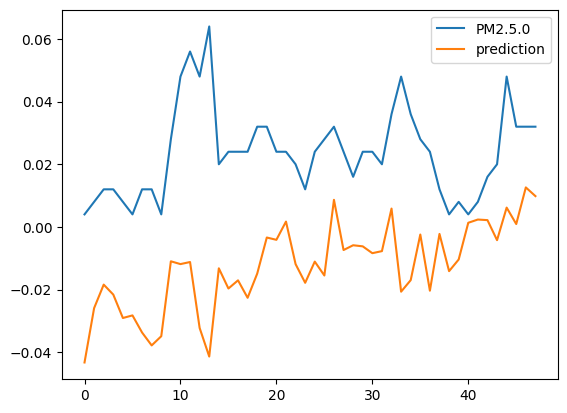

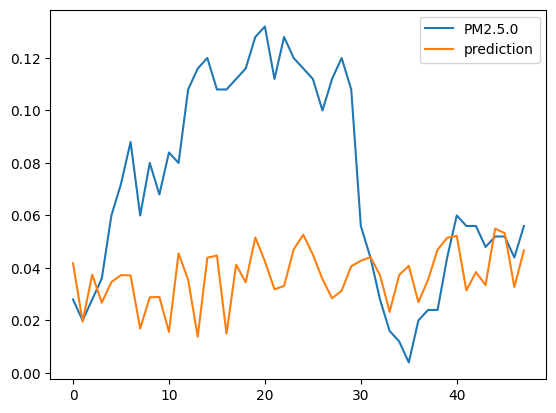

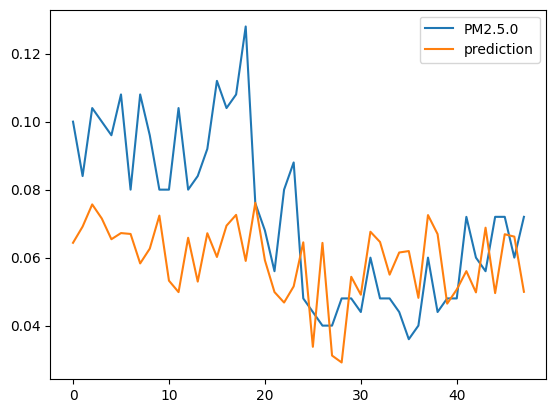

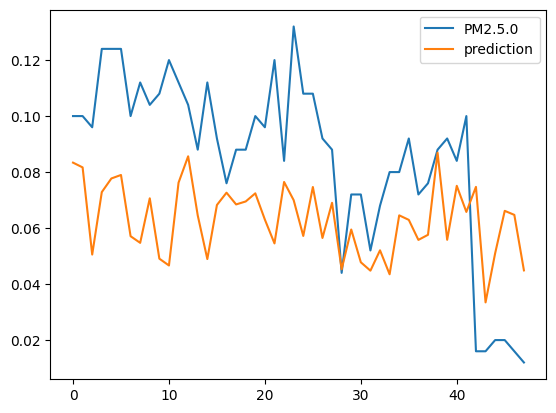

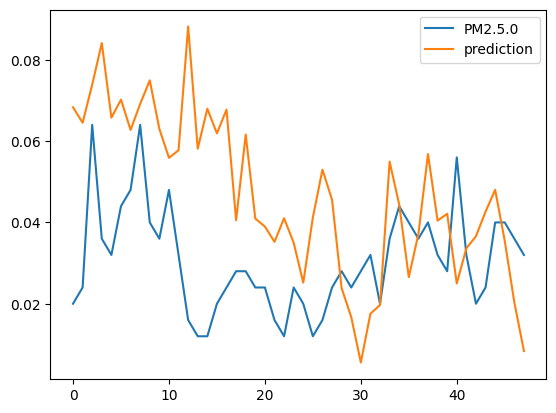

In [ ]:
actual_pred_plot(GRU_prediction, 1000)
actual_pred_plot(GRU_prediction, 1050)
actual_pred_plot(GRU_prediction, 1100)
actual_pred_plot(GRU_prediction, 1150)
actual_pred_plot(GRU_prediction, 1200)

### GRU_new - 2

In [ ]:
#GRU_new - 2
def GRU_new2(X_train, Y_train, X_val, sc_):
    from keras.models import Sequential
    from keras.layers import Dense, SimpleRNN, GRU, Permute, Flatten
    from keras.optimizers import Adam

    # The GRU architecture
    my_GRU_model = Sequential()
    #my_GRU_model.add(keras.layers.Flatten())
    my_GRU_model.add(GRU(units = 100,
                         dropout = 0.3,
                         return_sequences = True,
                         input_shape = ((60, 151)),
                         activation = 'tanh'))

    my_GRU_model.add(GRU(units = 150,
                         return_sequences = True,
                         activation = 'tanh'))

    my_GRU_model.add(GRU(units = 60,
                         activation = 'tanh'))

    #my_GRU_model.add(Flatten()) ## return_sequence = True (output shape = 3d), False (output shape = 2d)

    my_GRU_model.add(Dense(units = 48))

    # Compiling the RNN
    my_GRU_model.compile(optimizer = Adam(learning_rate=0.005, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False),
                         loss = 'mean_squared_error')
    # Fitting to the trainig set
    history = my_GRU_model.fit(X_train, Y_train, epochs = 5, batch_size = 100, verbose = 1, validation_data=(X_val, Y_val))

    GRU_prediction = my_GRU_model.predict(X_val)
    print(GRU_prediction.shape)
    #GRU_prediction = sc_.inverse_transform(GRU_prediction)
    #GRU_prediction[:, :] = ((GRU_prediction[:, :] - sc[0][0])/(sc[0][1] - sc[0][0]))

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.legend(['train','val'])
    plt.show()
    return my_GRU_model, GRU_prediction

# (batch_size, time_seq, features)

Epoch 1/5
306/306 [==============================] - 15s 30ms/step - loss: 0.0068 - val_loss: 0.0026
Epoch 2/5
306/306 [==============================] - 7s 24ms/step - loss: 0.0035 - val_loss: 0.0026
Epoch 3/5
306/306 [==============================] - 4s 13ms/step - loss: 0.0031 - val_loss: 0.0024
Epoch 4/5
306/306 [==============================] - 4s 14ms/step - loss: 0.0028 - val_loss: 0.0025
Epoch 5/5
136/136 [==============================] - 2s 5ms/step
(4335, 48)


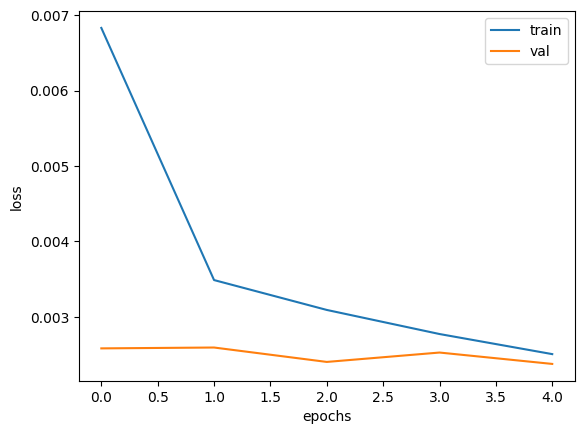

In [ ]:
my_GRU_model2, GRU_prediction2 = GRU_new2(X_train, Y_train, X_val, sc)

In [ ]:
GRU_prediction2

array([[0.02977351, 0.03081778, 0.0314802 , ..., 0.04285562, 0.03635696,
        0.04046854],
       [0.0272384 , 0.02850815, 0.02984263, ..., 0.0411152 , 0.03501592,
        0.03855205],
       [0.02672223, 0.02674774, 0.02972722, ..., 0.03982543, 0.03337688,
        0.03610297],
       ...,
       [0.3305924 , 0.33106345, 0.31526408, ..., 0.20260441, 0.21375637,
        0.20634337],
       [0.33422825, 0.3315158 , 0.31959274, ..., 0.21457791, 0.22362266,
        0.21452363],
       [0.34007677, 0.33617982, 0.32467598, ..., 0.22803128, 0.23327821,
        0.22432949]], dtype=float32)

(0.00019698597, <Axes: >)

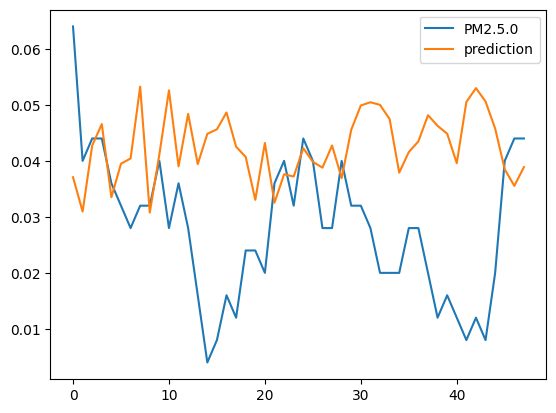

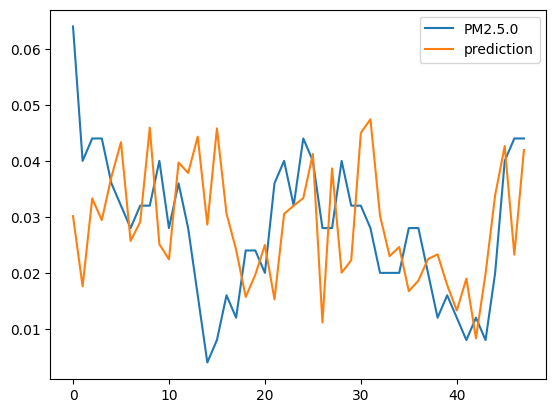

In [ ]:
actual_pred_plot(GRU_prediction2, 10)
actual_pred_plot(GRU_prediction, 10)

### GRU_new - 3

In [ ]:
#GRU_new - 3
def GRU_new3(X_train, Y_train, X_val, sc_):
    from keras.models import Sequential
    from keras.layers import Dense, SimpleRNN, GRU, Permute, Flatten
    from keras.optimizers import Adam

    # The GRU architecture
    my_GRU_model = Sequential()
    #my_GRU_model.add(keras.layers.Flatten())
    my_GRU_model.add(GRU(units = 100,
                         dropout = 0.3,
                         return_sequences = True,
                         input_shape = ((60, 151)),
                         activation = 'tanh'))

    my_GRU_model.add(GRU(units = 150,
                         return_sequences = True,
                         activation = 'tanh'))

    my_GRU_model.add(GRU(units = 60,
                         activation = 'tanh'))

    #my_GRU_model.add(Flatten()) ## return_sequence = True (output shape = 3d), False (output shape = 2d)

    my_GRU_model.add(Dense(units = 48))

    # Compiling the RNN
    my_GRU_model.compile(optimizer = Adam(learning_rate=0.008, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False),
                         loss = 'mean_squared_error')
    # Fitting to the trainig set
    history = my_GRU_model.fit(X_train, Y_train, epochs = 8, batch_size = 200, verbose = 1, validation_data=(X_val, Y_val))

    GRU_prediction = my_GRU_model.predict(X_val)
    print(GRU_prediction.shape)
    #GRU_prediction = sc_.inverse_transform(GRU_prediction)
    #GRU_prediction[:, :] = ((GRU_prediction[:, :] - sc[0][0])/(sc[0][1] - sc[0][0]))

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.legend(['train','val'])
    plt.show()
    return my_GRU_model, GRU_prediction

# (batch_size, time_seq, features)

Epoch 1/8
153/153 [==============================] - 18s 32ms/step - loss: 0.0125 - val_loss: 0.0027
Epoch 2/8
153/153 [==============================] - 3s 19ms/step - loss: 0.0036 - val_loss: 0.0025
Epoch 3/8
153/153 [==============================] - 3s 21ms/step - loss: 0.0034 - val_loss: 0.0033
Epoch 4/8
153/153 [==============================] - 3s 22ms/step - loss: 0.0032 - val_loss: 0.0026
Epoch 5/8
153/153 [==============================] - 3s 19ms/step - loss: 0.0030 - val_loss: 0.0024
Epoch 6/8
153/153 [==============================] - 3s 20ms/step - loss: 0.0027 - val_loss: 0.0027
Epoch 7/8
153/153 [==============================] - 3s 20ms/step - loss: 0.0026 - val_loss: 0.0028
Epoch 8/8
136/136 [==============================] - 2s 6ms/step
(4335, 48)


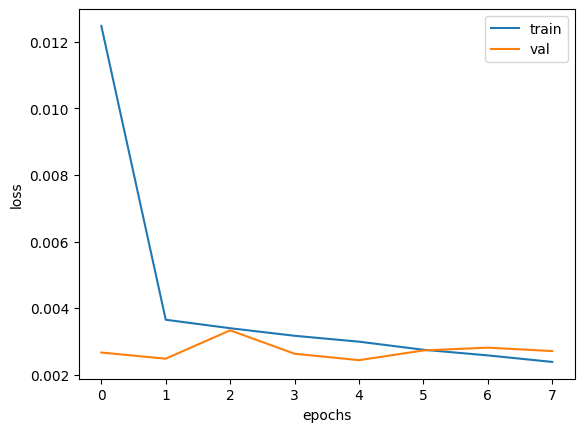

In [ ]:
my_GRU_model3, GRU_prediction3 = GRU_new3(X_train, Y_train, X_val, sc)

In [ ]:
GRU_prediction3

array([[0.03616864, 0.04141392, 0.03504309, ..., 0.02497081, 0.02498398,
        0.01600401],
       [0.03352664, 0.04035618, 0.03457703, ..., 0.0246059 , 0.02394817,
        0.01490168],
       [0.03213116, 0.03952353, 0.03560901, ..., 0.02292141, 0.02199886,
        0.01504997],
       ...,
       [0.28212863, 0.32634088, 0.32859296, ..., 0.1500553 , 0.12026595,
        0.12757736],
       [0.28478375, 0.32493365, 0.322934  , ..., 0.16460782, 0.12825967,
        0.14214756],
       [0.29499614, 0.33369756, 0.32733953, ..., 0.17786606, 0.13487305,
        0.15129998]], dtype=float32)

(0.00020178391, <Axes: >)

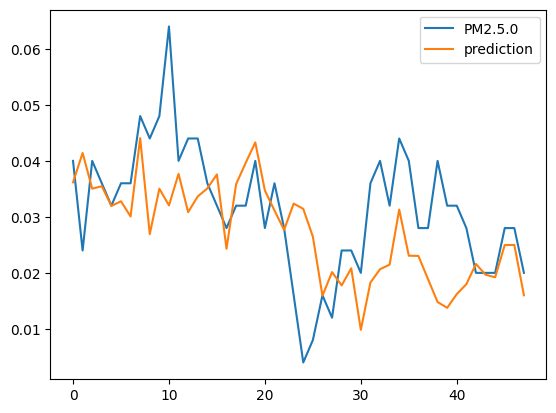

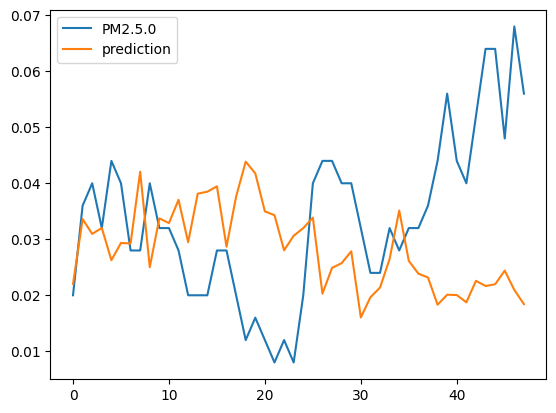

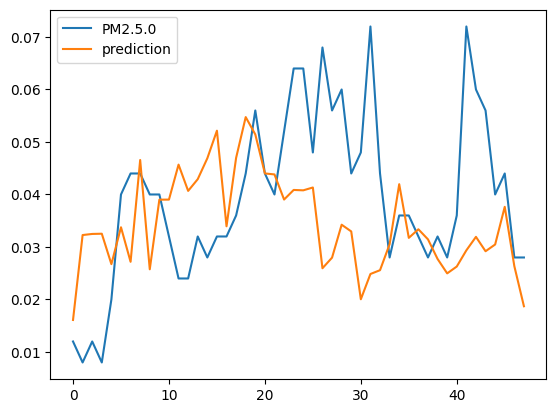

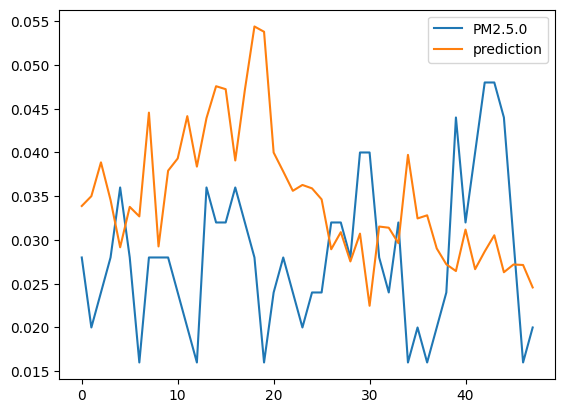

In [ ]:
actual_pred_plot(GRU_prediction3, 0)
actual_pred_plot(GRU_prediction3, 30)
actual_pred_plot(GRU_prediction3, 50)
actual_pred_plot(GRU_prediction3, 100)

(0.00025029338, <Axes: >)

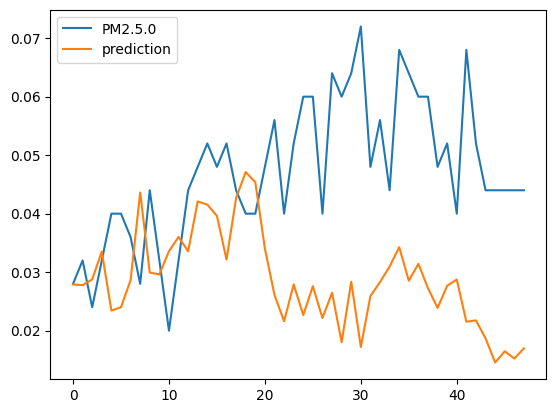

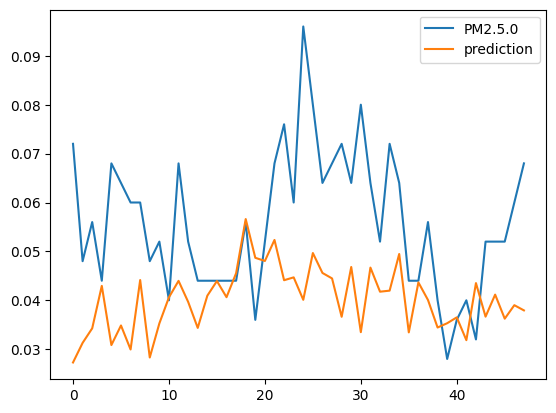

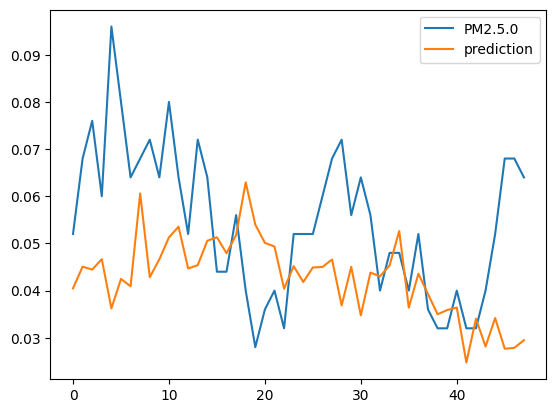

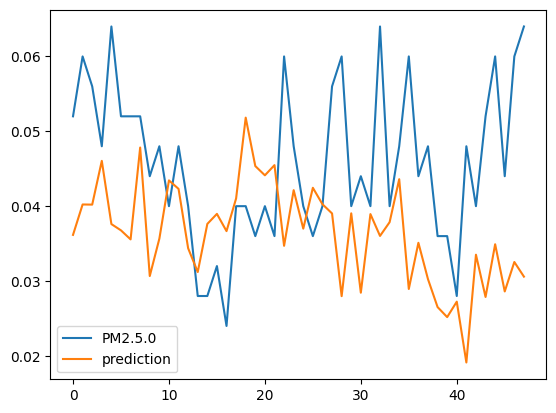

In [ ]:
actual_pred_plot(GRU_prediction3, 200)
actual_pred_plot(GRU_prediction3, 230)
actual_pred_plot(GRU_prediction3, 250)
actual_pred_plot(GRU_prediction3, 300)